In [2]:
import glob
import os
import gdal
import rasterio
import csv
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import os
import pylab
import random
import sys
import math

['E:\\Desktop\\定量遥感与农业应用\\TM\\band2.dat', 'E:\\Desktop\\定量遥感与农业应用\\TM\\band3.dat', 'E:\\Desktop\\定量遥感与农业应用\\TM\\band4.dat', 'E:\\Desktop\\定量遥感与农业应用\\TM\\band6.dat']


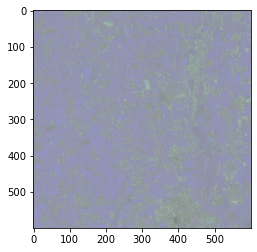

In [3]:
basepath=r"E:\Desktop\定量遥感与农业应用\TM"    
outpath=r"E:\Desktop\定量遥感与农业应用\TM\out.tif"
band=glob.glob(r"E:\Desktop\定量遥感与农业应用\TM\*.dat")     #glob函数获取dat文件
print(band)
array1=[]         #,读取二进制波段文件，将波段数据读为一维矩阵
for i in range(len(band)):
    ar=np.fromfile(band[i],dtype='uint8')
    array1.append(ar)
area1=np.arange(1440000).reshape(600,600,4)   #定义0-1439999的600*600*4矩阵
#读取范围
row1=2600
col1=3000
startnum=row1*6503+col1
#裁剪
for i in range(600):
    for j in range(600):
        for k in range(4):
            area1[i][j][k]=array1[k][(row1+i)*6503+col1+j]
#print(area1)

plt.imshow(area1)   #影像可视化
band_2=area1[0:600,0:600,0:1]       #矩阵按波段切片
#print(band_2.shape)
#print(band_2)
band_3=area1[0:600,0:600,1:2]
#print(band_3)
band_4=area1[0:600,0:600,2:3]
#print(band_4)
band_6=area1[0:600,0:600,3:4]
#print(band_6)
#area2=np.array(area1).reshape(4,500,500)
#area2=area1.transpose((2,1,0))
#print(area2)
#print(area2.size)
#print(area2[0])

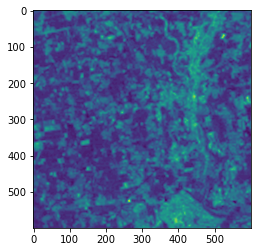

In [4]:
band_2=1.1751*band_2-2.84          #辐射定标
#print(band_2)
band_3=0.805765*band_3-1.17
band_4=0.814549*band_4-1.51
band_6=0.055158*band_6+1.2378
#print(band_6)
#print(band_1.shape)
area2=np.c_[band_2,band_3,band_4,band_6]        #矩阵合并
#print(area2.shape)    #查看矩阵维度属性
#print(area2)
#area3=area2.transpose((2,1,0))
#area3=area2.astype(np.int32)  #浮点转整数
#print(area3)
plt.imshow(band_2)      #可视化
plt.imshow(band_3) 
plt.imshow(band_4) 
plt.imshow(band_6) 
pylab.show()

1.0
-1.0


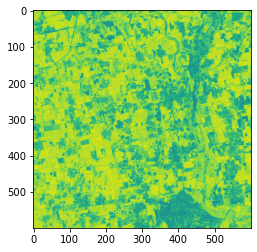

In [6]:
def normalize(arr,threshold=1):
    return threshold * (arr-arr.min())/(arr.max()-arr.min())         #归一化处理
band_2=normalize(band_2)
band_3=normalize(band_3)
band_4=normalize(band_4)
band_6=normalize(band_6)
NDVI=(band_4-band_3)/(band_4+band_3)
#print(NDVI)
print(np.max(NDVI))
print(np.min(NDVI))
plt.imshow(NDVI)

196.61154527764134 0.0


C:\Users\dell\AppData\Local\conda\conda\envs\mr\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


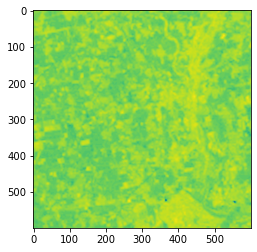

In [8]:
#计算亮温BT指数
L=607.76/band_6+1
#print(L)
#print(L)
K=np.log(L)
#print(K)
bt=1260.56/(K)
#BT=bt.astype(np.int32)  
#print(bt)
plt.imshow(bt)
a=np.max(bt)
b=np.min(bt)
print(a,b)

C:\Users\dell\AppData\Local\conda\conda\envs\mr\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


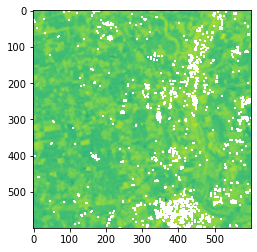

In [10]:
#计算地表温度LST
y=np.log(NDVI)
#print(y)
yita=1.009+0.047*y
LST=bt/pow(yita,1/4)
#print(LST)
plt.imshow(LST)

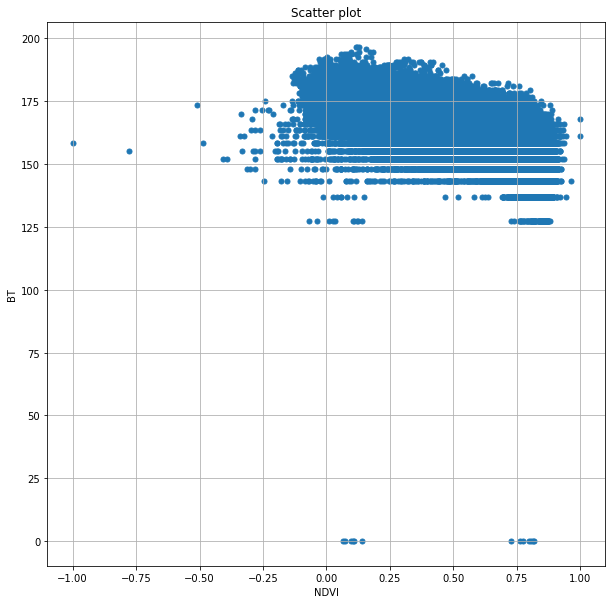

In [11]:
fig=plt.figure(figsize=(10,10),facecolor='white')   #设置画布
ax=fig.add_subplot(1,1,1)
ax.scatter(NDVI,bt,s=5**2)  #设置x轴为NDVI，y轴为BT
plt.title("Scatter plot")      #图名
plt.xlabel("NDVI")  #x轴标签
plt.ylabel("BT")   #y轴标签
plt.tick_params(axis='both')  #坐标轴刻度
plt.grid()
plt.show()

In [7]:
ndvi1=np.array(NDVI).reshape(360000,1)      
bt1=np.array(bt).reshape(360000,1)           #转变一维数组
#print(bt1)
def RangeFit(ndvi1,inf):#找到冷热边界
    lxmin=[]
    lymin=[]
    lxmax=[]
    lymax=[]
    batch=1/100           #设定步长
    for k in range(0,100):
        lxmin.append(None)
        lxmax.append(None)
        lymin.append(None)
        lymax.append(None)
    for i in range(0,ndvi1.shape[0]):        #生成区间，遍历像素值，放入相应区间并取每个区间BT的最值
        for j in range(0,ndvi1.shape[1]):
            if ndvi1[i,j]==1:
                index=99
            elif ndvi1[i,j]<=0:
                index=0
            else:
                index=int((ndvi1[i,j])/batch)
                
            if(lxmin[index] is None):
                lxmin[index]=ndvi1[i,j]
                lxmax[index]=ndvi1[i,j]
                lymin[index]=inf[i,j]
                lymax[index]=inf[i,j]
            else:
                if inf[i,j]>lymax[index]:
                    lymax[index]=inf[i,j]
                    lxmax[index]=ndvi1[i,j]
                if inf[i,j]<lymin[index]:
                    lymin[index]=inf[i,j]
                    lxmin[index]=ndvi1[i,j]           
    t=0
    while t<len(lxmin):         #去除BT=0的部分
        if lxmin[t]==None:
            lxmin.pop(t)
            lymin.pop(t)
            lxmax.pop(t)
            lymax.pop(t)
        else:
            t+=1
    p1=np.poly1d(np.polyfit(lxmin,lymin,1))
    p2=np.poly1d(np.polyfit(lxmax,lymax,1))
    return (p1,p2)        #返回冷热边界参数值
hhh=RangeFit(ndvi1,bt1)
print(hhh)

(poly1d([  8.06646321, 118.20337319]), poly1d([-28.5096201 , 197.45996118]))


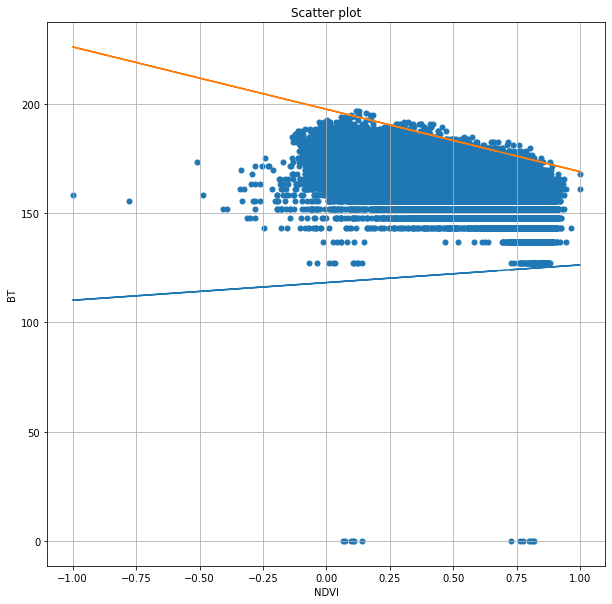

In [8]:
def l1(x):
    return 8.06646321*x+118.20337319       #冷边界
def l2(x):
    return -28.5096201*x+197.45996118      #热边界
#x1=np.arange(-1,1, 0.01)
y1=l1(ndvi1)
#x2=np.arange(-1,1, 0.01)
y2=l2(ndvi1)
fig=plt.figure(figsize=(10,10),facecolor='white')   #设置画布
ax=fig.add_subplot(1,1,1)
ax.scatter(NDVI,bt,s=5**2)  #设置x轴为NDVI，y轴为BT
plt.title("Scatter plot")      #图名
plt.xlabel("NDVI")  #x轴标签
plt.ylabel("BT")   #y轴标签
plt.tick_params(axis='both')  #坐标轴刻度
plt.plot(ndvi1,y1)      #绘制冷边界
plt.plot(ndvi1,y2)      #绘制热边界
plt.grid()
plt.show()
#bt1=8.06646321*ndvi1+118.20337319
#bt1=-28.5096201*ndvi1+197.45996118
#plt.plot(ndvi1,bt1)

[[[0.23032523]
  [0.24190153]
  [0.25196933]
  ...
  [0.33645188]
  [0.27948344]
  [0.22494974]]

 [[0.26146504]
  [0.24190153]
  [0.29859933]
  ...
  [0.2590439 ]
  [0.14160537]
  [0.27284425]]

 [[0.27012347]
  [0.27012347]
  [0.28923593]
  ...
  [0.2357433 ]
  [0.21870272]
  [0.20822267]]

 ...

 [[0.45002811]
  [0.44921887]
  [0.52522159]
  ...
  [0.26146504]
  [0.20555302]
  [0.18745678]]

 [[0.53008771]
  [0.53819041]
  [0.53502714]
  ...
  [0.25625421]
  [0.24712103]
  [0.21015556]]

 [[0.52674173]
  [0.53245684]
  [0.53245684]
  ...
  [0.25794551]
  [0.25299989]
  [0.20680995]]]


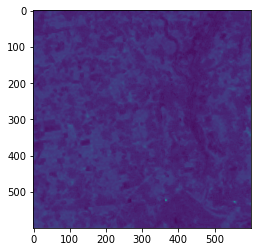

In [9]:
y11=np.array(y1).reshape(600,600,1)      #转为三维
y22=np.array(y2).reshape(600,600,1)
VTCI=(y22-bt)/(y22-y11)      #计算VTCI
print(VTCI)
plt.imshow(VTCI)